# 模型部署流程 Plug and Play Moduls

参考文献：

1. https://zhuanlan.zhihu.com/p/589411751：部署与量化的整个流程；
2. https://blog.csdn.net/qq_34218078/article/details/127521819：PTQ静态对称量化的pytorch实现


待阅读：
1. https://mp.weixin.qq.com/s?__biz=Mzg3ODU2MzY5MA==&mid=2247488318&idx=1&sn=048c1b78f3b2cb25c05abb115f20d6c6&chksm=cf108b3bf867022d1b214928102d65ed691c81955b59ca02bccdee92584ad9aa8e390e1d2978#rd
必看部署系列~懂你的神经网络量化教程：第一讲！
2. https://github.com/Susan19900316/yolov5_tensorrt_int8/tree/master 
   对TRT INT8优化的python实现
3. 

## Step1: 模型离线训练和压缩pytroch模型训练

模型剪枝、蒸馏两个技巧

### 模型剪枝

#### 细粒度剪枝  BCK1K2中的K1K2中的有规则的一些点位

在掩码剪枝中，一旦生成了掩码矩阵（通常是一个与权重矩阵同形状的二进制矩阵），你可以直接使用掩码与权重进行元素级别的运算，而无需再遍历整个矩阵。这使得剪枝的过程可以通过向量化操作来加速，尤其是在使用 GPU 时，向量化和矩阵操作比逐元素遍历更高效。

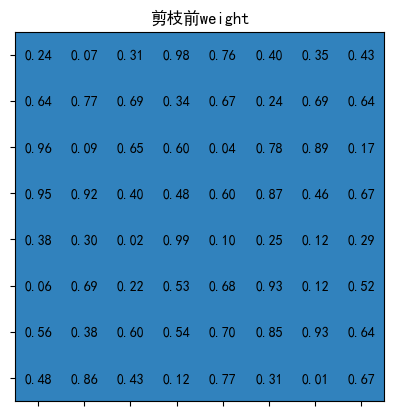

_fine_grained_prune 函数的执行时间为：0.00099945 秒


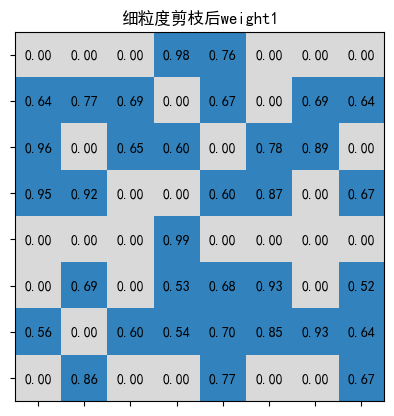

fine_grained_prune 函数的执行时间为：0.00000000 秒


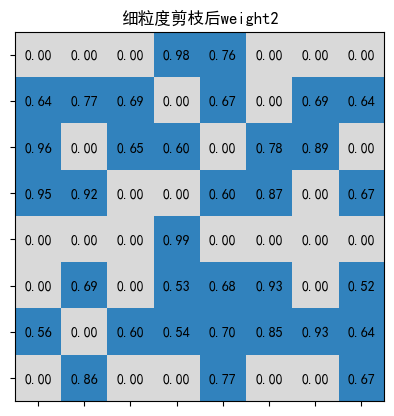

In [5]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文乱码

def timing_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        execution_time = end_time - start_time
        print("{} 函数的执行时间为：{:.8f} 秒".format(func.__name__, execution_time))
        return result
    return wrapper


# 创建一个可视化2维矩阵函数，将值为0的元素与其他区分开（用于显示剪枝效果）
def plot_tensor(tensor, title):
    # 创建一个新的图像和轴
    fig, ax = plt.subplots()

    # 使用 CPU 上的数据，转换为 numpy 数组，并检查相等条件，设置颜色映射
    ax.imshow(tensor.cpu().numpy() == 0, vmin=0, vmax=1, cmap='tab20c')
    ax.set_title(title)
    ax.set_yticklabels([])
    ax.set_xticklabels([])

    # 遍历矩阵中的每个元素并添加文本标签
    for i in range(tensor.shape[1]):
        for j in range(tensor.shape[0]):
            text = ax.text(j, i, f'{tensor[i, j].item():.2f}', ha="center", va="center", color="k")

    # 显示图像
    plt.show()


def test_plot_tensor():
    weight = torch.tensor([[-0.46, -0.40, 0.39, 0.19, 0.37],
                           [0.00, 0.40, 0.17, -0.15, 0.16],
                           [-0.20, -0.23, 0.36, 0.25, 0.03],
                           [0.24, 0.41, 0.07, 0.00, -0.15],
                           [0.48, -0.09, -0.36, 0.12, 0.45]])
    plot_tensor(weight, 'weight')


# 细粒度剪枝方法1
@timing_decorator
def _fine_grained_prune(tensor: torch.Tensor, threshold: float) -> torch.Tensor:
    """
    遍历矩阵中每个元素，如果元素值小于阈值，则将其设置为0。
    参数太大的话，遍历会影响到速度，下面将介绍在剪枝中常用的一种方法，即使用mask掩码矩阵来实现。
    :param tensor: 输入张量，包含需要剪枝的权重。
    :param threshold: 阈值，用于判断权重的大小。
    :return: 剪枝后的张量。
    """
    for i in range(tensor.shape[1]):
        for j in range(tensor.shape[0]):
            if tensor[i, j] < threshold:
                tensor[i][j] = 0
    return tensor


# 细粒度剪枝方法2
@timing_decorator
def fine_grained_prune(tensor: torch.Tensor, threshold: float) -> torch.Tensor:
    """
    创建一个掩码张量，指示哪些权重不应被剪枝（应保持非零）。
    :param tensor: 输入张量，待剪枝的权重。
    :param threshold: 阈值，用于判断权重的大小。
    :return: 剪枝后的张量。
    """
    mask = torch.gt(tensor, threshold)
    tensor.mul_(mask)
    return tensor


if __name__ == '__main__':
    # 创建一个矩阵weight
    weight = torch.rand(8, 8)
    plot_tensor(weight, '剪枝前weight')
    pruned_weight1 = _fine_grained_prune(weight, 0.5)
    plot_tensor(weight, '细粒度剪枝后weight1')
    pruned_weight2 = fine_grained_prune(weight, 0.5)
    plot_tensor(pruned_weight2, '细粒度剪枝后weight2')


#### 基于模式的剪枝 BCHW中的HW中的有模式的一些点位

基于模式的剪枝（Pattern-based Pruning） 是一种通过预定义的模式来决定剪枝的权重的剪枝方法。在这种方法中，剪枝不再是基于单个权重的大小或者梯度，而是基于一组预定义的剪枝模式，模式决定了哪些权重需要被剪枝，哪些需要保留。

示例：定义 6 种可能的剪枝模式，表示从 4 个权重中选择 2 个权重为 0 的方式。例如，如果我们用 1 表示保留的权重，用 0 表示被剪枝的权重，那么 6 种可能的模式如下：1100 1010 1001 0110 0101 0011。

每一种模式都表示剪枝过程中保留的权重和被剪枝的权重的组合

通过计算每个样本与模式的匹配度，并选择最佳匹配的模式。见：https://www.cnblogs.com/passion2021/p/18548165

In [ ]:
import torch
import matplotlib.pyplot as plt
from itertools import permutations


def reshape_1d(tensor, m):
    # 转换成列为m的格式，若不能整除m则填充0
    if tensor.shape[1] % m > 0:
        mat = torch.FloatTensor(tensor.shape[0], tensor.shape[1] + (m - tensor.shape[1] % m)).fill_(0)
        mat[:, : tensor.shape[1]] = tensor
        return mat.view(-1, m)
    else:
        return tensor.view(-1, m)


def compute_valid_1d_patterns(m, n):
    patterns = torch.zeros(m)
    patterns[:n] = 1
    valid_patterns = torch.Tensor(list(set(permutations(patterns.tolist()))))
    return valid_patterns


def compute_mask(tensor, m, n):
    # tensor={tensor(8,8)}
    # 计算所有可能的模式  patterns={tensor(6,4)}
    patterns = compute_valid_1d_patterns(m, n)
    # 找到m:n最好的模式
    # mask={tensor(16,4)}
    mask = torch.IntTensor(tensor.shape).fill_(1).view(-1, m)  # 使用 -1 让 PyTorch 自动推导某一维的大小
    # mat={tensor(16,4)}
    mat = reshape_1d(tensor, m)
    # pmax={tensor(16,)} 16x4 4x6 = 16x6 -> argmax = 16
    pmax = torch.argmax(torch.matmul(mat.abs(), patterns.t()), dim=1)
    mask[:] = patterns[pmax[:]]     # 选取最好的模式
    mask = mask.view(tensor.shape)  # 得到8x8掩码矩阵
    return mask


def pattern_pruning(tensor, m, n):
    mask = compute_mask(weight, m, n)
    tensor.mul_(mask)
    return tensor


if __name__ == '__main__':
    # 创建一个矩阵weight
    weight = torch.rand(8, 8)
    plot_tensor(weight, '剪枝前weight')
    pruned_weight = pattern_pruning(weight, 4, 2)
    plot_tensor(pruned_weight, '剪枝后weight')

#### 向量级别剪枝  BCHW中的H或W

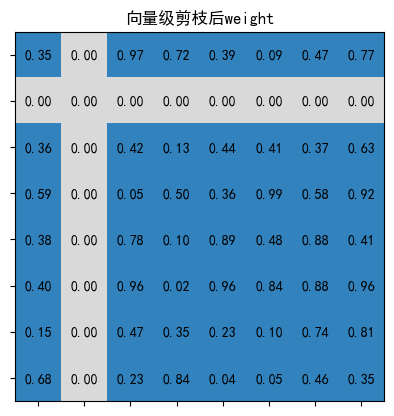

In [6]:
import torch
import matplotlib.pyplot as plt
from itertools import permutations

plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文乱码


# 剪枝某个点所在的行与列
def vector_pruning(weight, point):
    row, col = point
    prune_weight = weight.clone()
    prune_weight[row, :] = 0
    prune_weight[:, col] = 0
    return prune_weight

if __name__ == '__main__':
    weight = torch.rand(8, 8)
    point = (1, 1)
    prune_weight = vector_pruning(weight, point)
    plot_tensor(prune_weight, '向量级剪枝后weight')

#### 卷积核级别剪枝  BCK1K2中的某些K1K2

torch.Size([3, 10, 1, 1]) torch.Size([3, 10, 4, 5])
tensor(2.4050) [2.072694, 2.1961567, 2.2158406, 2.2233312, 2.3453228, 2.354322, 2.417608, 2.4601495, 2.4629967, 2.5085154, 2.5248275, 2.527996, 2.5387368, 2.551199, 2.5671835, 2.5715523, 2.5828288, 2.5943701, 2.6108723, 2.65446, 2.659494, 2.6683207, 2.7283623, 2.7698123, 2.809045, 2.83669, 2.849782, 2.8712473, 2.8996007, 2.9948838]


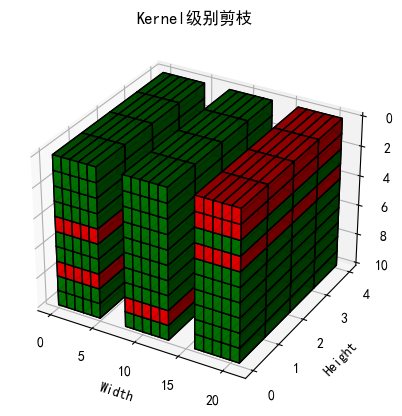

In [11]:
import torch
import matplotlib.pyplot as plt
from itertools import permutations

plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文乱码


# 定义可视化4维张量的函数
def visualize_tensor(tensor, title, batch_spacing=3):
    fig = plt.figure()  # 创建一个新的matplotlib图形
    ax = fig.add_subplot(111, projection='3d')  # 向图形中添加一个3D子图

    # 遍历张量的批次维度
    for batch in range(tensor.shape[0]):
        # 遍历张量的通道维度
        for channel in range(tensor.shape[1]):
            # 遍历张量的高度维度
            for i in range(tensor.shape[2]):
                # 遍历张量的宽度维度
                for j in range(tensor.shape[3]):
                    # 计算条形的x位置，考虑到不同批次间的间隔
                    x = j + (batch * (tensor.shape[3] + batch_spacing))
                    y = i  # 条形的y位置，即张量的高度维度
                    z = channel  # 条形的z位置，即张量的通道维度
                    # 如果张量在当前位置的值为0，则设置条形颜色为红色，否则为绿色
                    color = 'red' if tensor[batch, channel, i, j] == 0 else 'green'
                    # 绘制单个3D条形
                    ax.bar3d(x, y, z, 1, 1, 1, shade=True, color=color, edgecolor='black', alpha=0.9)

    ax.set_title(title)  # 设置3D图形的标题
    ax.set_xlabel('Width')  # 设置x轴标签，对应张量的宽度维度
    ax.set_ylabel('Height')  # 设置y轴标签，对应张量的高度维度
    ax.set_zlabel('Channel')  # 设置z轴标签，对于张量的通道维度
    ax.set_zlim(ax.get_zlim()[::-1])  # 反转z轴方向
    ax.zaxis.labelpad = 15  # 调整z轴标签的填充

    plt.show()  # 显示图形


def prune_conv_layer(conv_layer, title, percentile=0.2, ):
    prune_layer = conv_layer.clone()
    

    # 计算每个kernel的L2范数
    l2_norm = torch.norm(prune_layer, p=2, dim=(-2, -1), keepdim=True)
    # dim=(-2, -1)：这个参数指定了沿着哪些维度计算范数。
    # 在这个例子中，dim=(-2, -1) 表示沿着张量的最后两个维度计算范数，即 height 和 width 维度。
    # 这意味着对于每个卷积核（即 channels 维度上的每个元素），都会计算一个单独的范数。
    print(l2_norm.shape, prune_layer.shape)
    threshold = torch.quantile(l2_norm, percentile)                     # 根据指定的百分位数计算阈值
    # pos = (30 - 1) * 0.2 = 5.8
    # 由于位置 5.8 不是一个整数，torch.quantile 函数会进行插值计算，具体来说，它会取位置 5 和 6 上的元素，并根据它们的权重进行加权平均
    print(threshold, sorted(l2_norm.flatten().numpy()))
    mask = l2_norm > threshold
    prune_layer = prune_layer * mask.float()

    visualize_tensor(prune_layer, title=title)


if __name__ == '__main__':
    # 使用PyTorch创建一个张量
    tensor = torch.rand((3, 10, 4, 5))  # 3 batch size, 10 channels, 4 height, 5 width
    # 调用函数进行剪枝
    pruned_tensor = prune_conv_layer(tensor, 'Kernel级别剪枝')


#### 过滤器级别剪枝 BCK1K2中的CK1K2

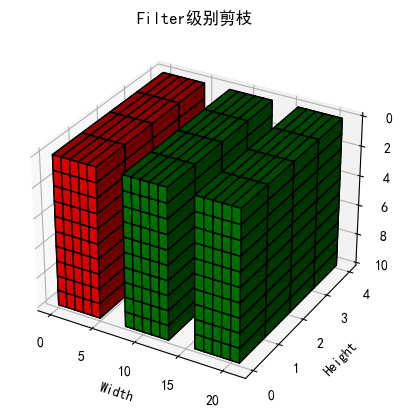

In [13]:
import torch
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文乱码


# 定义可视化4维张量的函数
def visualize_tensor(tensor, title, batch_spacing=3):
    fig = plt.figure()  # 创建一个新的matplotlib图形
    ax = fig.add_subplot(111, projection='3d')  # 向图形中添加一个3D子图

    # 遍历张量的批次维度
    for batch in range(tensor.shape[0]):
        # 遍历张量的通道维度
        for channel in range(tensor.shape[1]):
            # 遍历张量的高度维度
            for i in range(tensor.shape[2]):
                # 遍历张量的宽度维度
                for j in range(tensor.shape[3]):
                    # 计算条形的x位置，考虑到不同批次间的间隔
                    x = j + (batch * (tensor.shape[3] + batch_spacing))
                    y = i  # 条形的y位置，即张量的高度维度
                    z = channel  # 条形的z位置，即张量的通道维度
                    # 如果张量在当前位置的值为0，则设置条形颜色为红色，否则为绿色
                    color = 'red' if tensor[batch, channel, i, j] == 0 else 'green'
                    # 绘制单个3D条形
                    ax.bar3d(x, y, z, 1, 1, 1, shade=True, color=color, edgecolor='black', alpha=0.9)

    ax.set_title(title)  # 设置3D图形的标题
    ax.set_xlabel('Width')  # 设置x轴标签，对应张量的宽度维度
    ax.set_ylabel('Height')  # 设置y轴标签，对应张量的高度维度
    ax.set_zlabel('Channel')  # 设置z轴标签，对于张量的通道维度
    ax.set_zlim(ax.get_zlim()[::-1])  # 反转z轴方向
    ax.zaxis.labelpad = 15  # 调整z轴标签的填充

    plt.show()  # 显示图形


def prune_conv_layer(conv_layer, prune_method, title="", percentile=0.2, vis=True):
    prune_layer = conv_layer.clone()

    l2_norm = None
    mask = None

    # 计算每个Filter的L2范数
    l2_norm = torch.norm(prune_layer, p=2, dim=(1, 2, 3), keepdim=True)
    threshold = torch.quantile(l2_norm, percentile)
    mask = l2_norm > threshold
    prune_layer = prune_layer * mask.float()

    visualize_tensor(prune_layer, title=prune_method)

if __name__ == '__main__':
    # 使用PyTorch创建一个张量
    tensor = torch.rand((3, 10, 4, 5))

    # 调用函数进行剪枝

    pruned_tensor = prune_conv_layer(tensor, 'Filter级别剪枝', vis=True)

#### 通道级别剪枝  BCK1K2中的某些C对应的所有的K1K2

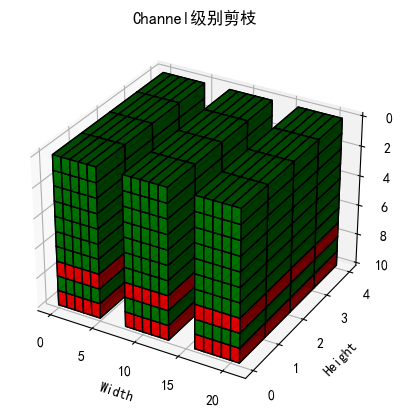

In [15]:
import torch
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文乱码


# 定义可视化4维张量的函数
def visualize_tensor(tensor, title, batch_spacing=3):
    fig = plt.figure()  # 创建一个新的matplotlib图形
    ax = fig.add_subplot(111, projection='3d')  # 向图形中添加一个3D子图

    # 遍历张量的批次维度
    for batch in range(tensor.shape[0]):
        # 遍历张量的通道维度
        for channel in range(tensor.shape[1]):
            # 遍历张量的高度维度
            for i in range(tensor.shape[2]):
                # 遍历张量的宽度维度
                for j in range(tensor.shape[3]):
                    # 计算条形的x位置，考虑到不同批次间的间隔
                    x = j + (batch * (tensor.shape[3] + batch_spacing))
                    y = i  # 条形的y位置，即张量的高度维度
                    z = channel  # 条形的z位置，即张量的通道维度
                    # 如果张量在当前位置的值为0，则设置条形颜色为红色，否则为绿色
                    color = 'red' if tensor[batch, channel, i, j] == 0 else 'green'
                    # 绘制单个3D条形
                    ax.bar3d(x, y, z, 1, 1, 1, shade=True, color=color, edgecolor='black', alpha=0.9)

    ax.set_title(title)  # 设置3D图形的标题
    ax.set_xlabel('Width')  # 设置x轴标签，对应张量的宽度维度
    ax.set_ylabel('Height')  # 设置y轴标签，对应张量的高度维度
    ax.set_zlabel('Channel')  # 设置z轴标签，对于张量的通道维度
    ax.set_zlim(ax.get_zlim()[::-1])  # 反转z轴方向
    ax.zaxis.labelpad = 15  # 调整z轴标签的填充

    plt.show()  # 显示图形


def prune_conv_layer(conv_layer, prune_method, title="", percentile=0.2, vis=True):
    prune_layer = conv_layer.clone()

    l2_norm = None
    mask = None

    # 计算每个channel的L2范数
    l2_norm = torch.norm(prune_layer, p=2, dim=(0, 2, 3), keepdim=True)
    threshold = torch.quantile(l2_norm, percentile)
    mask = l2_norm > threshold
    prune_layer = prune_layer * mask.float()

    visualize_tensor(prune_layer, title=prune_method)


# 使用PyTorch创建一个张量
tensor = torch.rand((3, 10, 4, 5))

# 调用函数进行剪枝

pruned_tensor = prune_conv_layer(tensor, 'Channel级别剪枝', vis=True)

## 📕Step2: pytorch模型转换为TRT模型

torch2trt

torch-onnx-trt

In [3]:
import torch,os
import torchvision
from torch2trt import torch2trt

# 预构建模型
# model_torch_path = "./resources/ori/yolov5n.pt"  # 确保torch模型是包含模型结构的。
model = torch.hub.load("ultralytics/yolov5", "yolov5n")  
#? Using cache found in C:\Users\Lixutong/.cache\torch\hub\ultralytics_yolov5_master

Using cache found in C:\Users\Lixutong/.cache\torch\hub\ultralytics_yolov5_master


ModuleNotFoundError: No module named 'ultralytics'

### torch2trt

将yolov5模型转换为tensorrt模型

torch2trt  https://github.com/NVIDIA-AI-IOT/torch2trt ; 最近一次的更新是在9个月之前

In [ ]:
"""
model = torch.load(model_path).eval().cuda()
在评估模式下，模型不会应用 Dropout 和 Batch Normalization 等技术，这可以提高模型在推理阶段的准确性。
在评估模式下，模型的行为是确定性的，这意味着对于相同的输入，模型将始终产生相同的输出。这对于模型的可重复性非常重要，特别是在需要进行模型比较或验证的情况下。（避开了Dropout 和 Batch Normalization、一开始的随机初始化和数据预处理时的数据增强）
"""



def convert_torch_trt(model_torch, model_input):
    # 将 PyTorch 模型转换为 TensorRT 模型
    model_trt = torch2trt(model_torch, [model_input], keep_network=False)

    # 进行推理
    output = model_trt(model_input)

    # 输出结果
    print(output)
    
    return model_trt



# 加载 PyTorch 模型
model_torch_path = "./resources/ori/yolov5n.pt"  # 确保torch模型是包含模型结构的。
model_torch = torch.load(model_torch_path).eval().cpu()
model_trt_path = os.path.dirname(model_torch_path) + "/yolov5n_trt2.pt"  # 替换为你的模型文件路径


# 转换模型
input = torch.ones((1, 3, 224, 224)).cuda()
model_trt = convert_torch_trt(model_torch, input)


#! 保存 TensorRT 模型(这里仅仅保存了模型的参数)
torch.save(model_trt.state_dict(), model_trt_path)

ModuleNotFoundError: No module named 'models'

### torch--onnx--trt

众多案例见相关的文件：onnx2trt.py and export_onnx.py

In [ ]:
## torch2onnx

def export_clip_model(clip_model):
    # clip_model = hk.model.cond_stage_model  
    #? 从某种程度上需要知道为啥选择self.model的cond_stage_model，
    # 其实这个模型实际上是FrozenClipEmbdding模型的实例化对象，包含了tonkenizer和transoformer模型；

    import types

    def forward(self, tokens):
        outputs = self.transformer(
            input_ids=tokens, output_hidden_states=self.layer == "hidden"
        )
        if self.layer == "last":
            z = outputs.last_hidden_state
        elif self.layer == "pooled":
            z = outputs.pooler_output[:, None, :]
        else:
            z = outputs.hidden_states[self.layer_idx]
        return z

    clip_model.forward = types.MethodType(forward, clip_model)   
    # 这里将clip_model的默认执行函数encode函数替换为forward函数；
    #? 为什么不能将tokenizer模型进行ONNX转换呢？
    # 主要原因是 tokenizer 通常是一个预处理步骤，它将文本输入转换为模型可以理解的格式（例如，将文本转换为整数索引）。这个过程通常不涉及复杂的计算，因此不需要使用 ONNX 进行优化。
    # 它将文本分割成一个个的token，构建词汇表，token映射ID，将文本序列转换成整数索引序列，有时为了确保所有输入序列长度相同，会在短序列后面添加特殊的pad token，或者进行截断。
    # tokenizer 负责将输入的文本转换为整数索引，而 transformer 模型则负责将这些整数索引转换为嵌入向量

    onnx_path = "./onnx/CLIP.onnx"

    tokens = torch.zeros(1, 77, dtype=torch.int32)
    # 77是每个输入序列的长度，NLP中通常会将本文序列转换成固定长度的整数索引序列，如果样本长度小于77会填充，如果超过则进行截断。
    # 77是一个经验值，通常需要根据实际需求和模型特点进行调整。
    
    
    #? onnx此时的input_names和output_names是必须要有的，后续onnx模型推理和trt模型推理需要用到；
    input_names = ["input_ids"]
    output_names = ["last_hidden_state"]

    torch.onnx.export(
        clip_model,
        (tokens),
        onnx_path,
        verbose=True,
        opset_version=18,
        do_constant_folding=True,    # 模型优化操作：常量折叠！牛批
        input_names=input_names,
        output_names=output_names,
    )
    print("======================= CLIP model export onnx done!")

    # verify onnx model
    output = clip_model(tokens)
    input_dicts = {"input_ids": tokens.numpy()}
    # onnxruntime_check(onnx_path, input_dicts, [output])
    
    print("======================= CLIP onnx model verify done!")
    
    torch_path = "./torch_model/CLIP.pt"
    torch.save(clip_model, torch_path)

In [ ]:
## onnx2trt
import numpy as np
import os
import tensorrt as trt

def onnx2trt(onnxFile, plan_name, min_shapes, opt_shapes, max_shapes, max_workspace_size = None, use_fp16=False, builder_opt_evel=None):
    logger = trt.Logger(trt.Logger.VERBOSE)                                                         # create logger
    builder = trt.Builder(logger)                                                                   # create builder
    config = builder.create_builder_config()                                                        # create config
    network = builder.create_network(1<<int(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH))      # create network
    
    if max_workspace_size:                                                                          # init config
        config.max_workspace_size = max_workspace_size
    else:
        config.max_workspace_size = 10<<30 # 10GB

    parser = trt.OnnxParser(network, logger)                                                         # create parser
    if not os.path.exists(onnxFile):
        print("Failed finding onnx file!")
        exit()
    print("Succeeded finding onnx file!")
    with open(onnxFile, 'rb') as model:
        # import pdb; pdb.set_trace()
        (onnx_path, _) = os.path.split(onnxFile)
        if not parser.parse(model.read(), path=onnxFile):                                            # parse onnx
            print("Failed parsing ONNX file!")
            for error in range(parser.num_errors):
                print(parser.get_error(error))
            exit()
    print("Succeeded parsing ONNX file!")

    if use_fp16:                                                                                      # init config
        config.set_flag(trt.BuilderFlag.FP16)
        plan_name = plan_name.replace(".plan", "_fp16.plan")

    if builder_opt_evel:
        config.builder_optimization_level = builder_opt_evel

    # set profile
    assert network.num_inputs == len(min_shapes)
    assert network.num_inputs == len(opt_shapes)
    assert network.num_inputs == len(max_shapes)

    profile = builder.create_optimization_profile()                                                   # create profile
    for i in range(network.num_inputs):                                                               # set profile
        input_tensor = network.get_input(i)
        profile.set_shape(input_tensor.name, tuple(min_shapes[i]), tuple(opt_shapes[i]), tuple(max_shapes[i]))

    config.add_optimization_profile(profile)                                                          # init config

    engine = builder.build_engine(network, config)                                                    # create engine
    if not engine:
        raise RuntimeError("build_engine failed")
    print("Succeeded building engine!")

    print("Serializing Engine...")
    serialized_engine = engine.serialize()                                                             # serialize engine
    if serialized_engine is None:
        raise RuntimeError("serialize failed")

    (plan_path, _) = os.path.split(plan_name)
    os.makedirs(plan_path, exist_ok=True)
    with open(plan_name, "wb") as fout:
        fout.write(serialized_engine)

In [ ]:
onnx_path = "./onnx/3_6_best.onnx"
plan_path = "./engine/3_6_best.plan"

# 静态shape；单一batch；非fp16；
onnx2trt(onnx_path, plan_path, [(1, 4, 32, 48)], [(1, 4, 32, 48)], [(1, 4, 32, 48)])

# 静态shape；单一batch；fp16；
onnx2trt(onnx_path, plan_path, [(1, 3, 1120, 1120)], [(1, 3, 1120, 1120)], [(1, 3, 1120, 1120)], use_fp16=True)

# 静态shape；拼batch；fp16；
onnx2trt(onnx_path, plan_path, [(2, 3, 1120, 1120)], [(2, 3, 1120, 1120)], [(2, 3, 1120, 1120)], use_fp16=True)

# 动态shape；拼batch；fp16；
onnx2trt(onnx_path, plan_path, [(2, 3, 1120, 1120)], [(4, 3, 1120, 1120)], [(8, 3, 1120, 1120)], use_fp16=True)

print("======================= Decoder  onnx2trt done!")

## 📕Step3: 模型onnx计算图节点优化

- [x] 节点裁剪（查询、删除、增加、替换）
- [ ] plugin合并
- [ ] 新节点开发

In [ ]:
# 本节导入库
import torch
import cv2, os,time
import numpy as np
import tensorrt as trt
import torch.nn as nn
import onnxruntime as rt

In [10]:
# 构建一个onnx模型
class DemoModel(torch.nn.Module):
    def __init__(self):
        super(DemoModel, self).__init__()
        self.conv = nn.Conv2d(in_channels=1,out_channels=1,kernel_size=1)
        self.relu = nn.ReLU()
        self.fc = torch.nn.Linear(2, 2)
 
    def forward(self, x):
        x = self.relu(x)
        x = self.relu(x)
        x = self.relu(x)
        x = self.conv(x)
        x = self.relu(x)
        x = self.fc(x)
        return x
    
model = DemoModel()
input = torch.randn(1,1,2,2)
torch.onnx.export(model, input, "./resources/onnx/demo.onnx", input_names=["input"], output_names=["output"])
print(model)

============== Diagnostic Run torch.onnx.export version 2.0.0+cpu ==============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

DemoModel(
  (conv): Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1))
  (relu): ReLU()
  (fc): Linear(in_features=2, out_features=2, bias=True)
)


https://blog.csdn.net/csdnsqst0050/article/details/137079485
onnx模型graph、node和tensor的属性

https://blog.csdn.net/jacke121/article/details/128059994
：包含了对PRelu激活函数的初始化张量修改，model.graph.initializer包含了模型中所有的初始化器，初始化器与模型中的节点关联。


In [ ]:
# 最近有遇到需要将onnx模型的中间节点裁剪掉的情况，mxnet转成的caff模型，预处理（减去均值除以方差的操作）写在了模型结构里，量化时要把预处理层单独拿出来，这个操作有两种方法可以实现，一种可以加载mxnet训练好的模型，去掉预处理后再保存；另一种时直接将onnx中对应的两个预处理节点裁掉，这里写一下第二种方法具体实现

import onnx_graphsurgeon as gs
import numpy as np
import onnx

# remove preprocessing node
# (x - mean)/std
def remove_preprocessing_node(onnx_path):
    onnx_model = onnx.load(onnx_path)    #加载onnx模型
    graph = onnx_model.graph
    old_nodes = graph.node
    
    # 📕查看onnx模型各个节点的名称
    for node in old_nodes:
        print("[original graph] node.name: {} ({}); input: {}; output: {}".format(node.name, node.op_type, node.input, node.output))
        # print(node.attribute) #? 📕查看节点的属性
    
    
    # 📕查询节点：通过node的上下文节点op类型来查询，并记录其在graph.node中的索引！
    for i in range(len(old_nodes)):
        if old_nodes[i].op_type == 'Constant':
            node_rise = node[i]
            if node_rise.output[0] == '449':
                print(i)  # 157
    
    
    # 📕删除前两个relu节点
    new_nodes = old_nodes[2:]               
    del onnx_model.graph.node[:]            # 删除当前onnx模型的所有node
    onnx_model.graph.node.extend(new_nodes) # extend新的节点
    
    relu_node = onnx_model.graph.node[0]   # 获取新的节点列表中的第一个节点，通常是卷积层的节点，并将其赋值给变量 conv0_node。
    relu_node.input[0] = 'input'            # 给第一层的卷积节点设置输入的data节点
    
    
    # 📕查看onnx模型各个节点的名称
    for node in onnx_model.graph.node:
        print("[target graph] node.name: {} ({}); input: {}; output: {}".format(node.name, node.op_type, node.input, node.output))
    
    
    # 📕将第三个relu转换成conv节点
    relu_node = onnx_model.graph.node[0]
    conv_node = onnx.helper.make_node(
        op_type="Conv",
        inputs=["input", 'conv.weight', 'conv.bias'],
        outputs=[relu_node.output[0]],
        name="conv0_0",
        kernel_shape=[3, 3],  # 卷积核的形状
        strides=[1, 1],       # 步长
        pads=[1, 1, 1, 1],    # 填充
        )
    
    # 📕 删除和插入节点
    # 替换 relu 节点为 conv 节点
    graph.node.remove(relu_node)  # remove会根据节点对象的引用来定位要删除的节点
    graph.node.insert(0, conv_node)  # append会将节点对象添加到列表末尾
    
    # 📕查看onnx模型各个节点的名称
    for node in onnx_model.graph.node:
        print("[target2 graph] node.name: {} ({}); input: {}; output: {}".format(node.name, node.op_type, node.input, node.output))

    
    # graph = onnx_model.graph
    # print(graph.node)
    onnx.checker.check_model(onnx_model)
    onnx.save(onnx_model, "./resources/onnx/demo_del_nodes.onnx")


if __name__ == "__main__":
    onnx_path = "./resources/onnx/demo.onnx"
    remove_preprocessing_node(onnx_path)

[original graph] node.name: /relu/Relu (Relu); input: ['input']; output: ['/relu/Relu_output_0']
[original graph] node.name: /relu_1/Relu (Relu); input: ['/relu/Relu_output_0']; output: ['/relu_1/Relu_output_0']
[original graph] node.name: /relu_2/Relu (Relu); input: ['/relu_1/Relu_output_0']; output: ['/relu_2/Relu_output_0']
[original graph] node.name: /conv/Conv (Conv); input: ['/relu_2/Relu_output_0', 'conv.weight', 'conv.bias']; output: ['/conv/Conv_output_0']
[original graph] node.name: /relu_3/Relu (Relu); input: ['/conv/Conv_output_0']; output: ['/relu_3/Relu_output_0']
[original graph] node.name: /fc/MatMul (MatMul); input: ['/relu_3/Relu_output_0', 'onnx::MatMul_13']; output: ['/fc/MatMul_output_0']
[original graph] node.name: /fc/Add (Add); input: ['fc.bias', '/fc/MatMul_output_0']; output: ['output']
[target graph] node.name: /relu_2/Relu (Relu); input: ['input']; output: ['/relu_2/Relu_output_0']
[target graph] node.name: /conv/Conv (Conv); input: ['/relu_2/Relu_output_0',

## 📕Step3: 模型Easy优化策略

FP16 CUDA_GRAPH BUILDOPTIMALLEVEL 拼Batch 

trtexec调试工具：trtexec --help 


trtexec

**onnx模型转换trt模型**

--**onnx=modelA.onnx**

--**saveEngine=model-02.plan**

--timingCacheFile=model-02.cache

**--minshapes=tensorX:1x1x28x28**

**--optshapes=tensorX:4x1x28x28**

**--maxShapes=tensorX:16x1x28x28**

**--fp16**

--nOTF32

--memPoolsize=workspace:1024MiB--builderoptimizationLevel=5

--maxAuxStreams=4

**--skipInference**

**--verbose**

**>result-02.log 2>&1**

**trt模型执行**

**trtexec model-02.plan**

--trt

**--shapes=tensorX:4x1x28x28**

--noDataTransfers

--usespinwait

**--usecudaGraph**

--verbose

**>result-03.log 2>&1**




In [ ]:
# FP16
# python脚本使用：在onnx2trt时指定fp16
# cli：1. trtexec --onnx=model.onnx --saveEngine=model_fp16.engine --fp16   # 生成engine文件
# cli：2. trtexec model_fp16.engine --trt                                   # 基于FP16测试推理

# cuda graph
# python脚本使用：engine.py中模型推理前判断是否使用cuda graph
# cli：1. trtexec --onnx=model.onnx --saveEngine=model_fp16.engine --fp16   # 生成engine文件
# cli：2. trtexec model_fp16.engine --trt  --cudaGraph                      # 基于FP16 + CUDAGRAPH测试推理

## BUILDOPTIMALLEVEL
# python脚本使用：onnx2trt.py中 config.builder_optimal_level = 3
# cli：1. trtexec --onnx=model.onnx --saveEngine=model_fp16.engine --builderOptimizationLevel   # 生成engine文件
# cli：2. trtexec model.engine --trt                                   # 测试推理

## 拼Batch
# python脚本使用：onnx2trt中通过profile.set_shape指定动态shape
# python脚本使用：torch.nn.export中指定dynamic_axes。
# cli：1. trtexec model.engine --trt                                   # 测试推理

## Step3: 模型Hard优化策略

INT8量化 模型深度加速

### trtexec量化

In [ ]:
# trtexec PTQ 量化

# int8量化 不推荐 无数据集校准 精度下降较大
#trtexec --onnx=XX.onnx --saveEngine=model.plan --int8 --workspace=4096

# int8和FP16混合量化 不推荐 无数据集校准 精度下降较大
#trtexec --onnx=XX.onnx --saveEngine=model.plan --int8 --fp16 --workspace=4096


### torch动态量化

In [ ]:
"""
只量化权重，不量化激活
"""
import torch
from torch import nn
 
class DemoModel(torch.nn.Module):
    def __init__(self):
        super(DemoModel, self).__init__()
        self.conv = nn.Conv2d(in_channels=1,out_channels=1,kernel_size=1)
        self.relu = nn.ReLU()
        self.fc = torch.nn.Linear(2, 2)
 
    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.fc(x)
        return x
 
 
if __name__ == "__main__":
    model_fp32 = DemoModel()
    # 创建一个量化的模型实例
    model_int8 = torch.quantization.quantize_dynamic(
        model=model_fp32,  # 原始模型
        qconfig_spec={torch.nn.Linear},  # 要动态量化的NN算子
        dtype=torch.qint8)  # 将权重量化为：float16 \ qint8
 
    print(model_fp32)
    print(model_int8)
 
    # 运行模型
    input_fp32 = torch.randn(1,1,2, 2)
    output_fp32 = model_fp32(input_fp32)
    print(output_fp32)
 
    output_int8 = model_int8(input_fp32)
    print(output_int8)

### torch静态量化

In [ ]:
"""
权重和激活都会被量化
"""
 
import torch
from torch import nn
 
 
# 定义一个浮点模型，其中一些层可以被静态量化
class F32Model(torch.nn.Module):
    def __init__(self):
        super(F32Model, self).__init__()
        self.quant = torch.quantization.QuantStub()      # QuantStub: 转换张量从浮点到量化
        self.conv = nn.Conv2d(1, 1, 1)
        self.fc = nn.Linear(2, 2, bias=False)
        self.relu = nn.ReLU()
        self.dequant = torch.quantization.DeQuantStub()  # DeQuantStub: 将量化张量转换为浮点
 
    def forward(self, x):
        x = self.quant(x)  # 手动指定张量: 从浮点转换为量化
        x = self.conv(x)
        x = self.fc(x)
        x = self.relu(x)
        x = self.dequant(x)  # 手动指定张量: 从量化转换到浮点
        return x
 
 
model_fp32 = F32Model()
model_fp32.eval()       # 模型必须设置为eval模式，静态量化逻辑才能工作
 
# 1、如果要部署在ARM上；果要部署在x86 server上 ‘fbgemm’
# model_fp32.qconfig = torch.ao.quantization.get_default_qconfig('qnnpack')
 # model_fp32.qconfig = torch.ao.quantization.get_default_qconfig('fbgemm')
model_fp32.qconfig = torch.ao.quantization.get_default_qat_qconfig('x86')   # x86 官方推荐的量化配置

# 2、在适用的情况下，将一些层进行融合，可以加速
# 常见的融合包括在：DEFAULT_OP_LIST_TO_FUSER_METHOD
# this needs to be done manually depending on the model architecture
model_fp32_fused = torch.ao.quantization.fuse_modules(model_fp32, [['fc', 'relu']])
 
# 3、准备模型，插入observers，观察 activation 和 weight
model_fp32_prepared = torch.ao.quantization.prepare(model_fp32_fused.train())
 
# 4、代表性数据集，获取数据的分布特点，来更好的计算activation的 scale 和 zp
input_fp32 = torch.randn(1, 1, 2, 2)  # (batch_size, channel, W, H)
model_fp32_prepared(input_fp32)
 
# 5、量化模型
model_fp32_prepared.eval()
model_int8 = torch.ao.quantization.convert(model_fp32_prepared)
 
# 运行模型，相关计算将在int8中进行
output_fp32 = model_fp32(input_fp32)
output_int8 = model_int8(input_fp32)
print(output_fp32)
# tensor([[[[0.6315, 0.0000],
#           [0.2466, 0.0000]]]], grad_fn=<ReluBackward0>)
print(output_int8)
# tensor([[[[0.3886, 0.0000],
#           [0.2475, 0.0000]]]])

tensor([[[[0.1144, 0.0000],
          [0.0765, 0.0000]]]], grad_fn=<ReluBackward0>)
tensor([[[[0.1165, 0.0000],
          [0.0762, 0.0000]]]])


## 📕Step4: 模型转换输出结果对比

三种模型形态，分别是torch，onnx，tensorrt

虽然模型形态不一致，但是实际输出结果的shape是一致的。因此可以不必区分模型输出所属的模型类别

In [ ]:
# 本节导入库
import torch
import cv2, os,time
import numpy as np
import tensorrt as trt
import onnxruntime as rt

### 检查转换前模型和转换后模型的输出是否一致

In [ ]:
# 构建一个 检查转换前模型和转换后模型的输出是否一致的函数
def check_model_output(original_outputs: np.array, converted_outputs: np.array):
    
    # 检查输出形状是否一致
    if original_outputs.shape != converted_outputs.shape:
        return False
    
    # 遍历每个样本
    for i in range(0, len(original_outputs)):
        single_original_output = original_outputs[i]
        single_converted_output = converted_outputs[i]
        
        # 检查1: 输出总和的差异在容忍度以内
        ret = np.allclose(single_original_output, single_converted_output, rtol=1e-03, atol=1e-05, equal_nan=False)
        
        if ret is False:
            print("[ERROR] onnxruntime_check")
            # 检测result[i]的输出中是否包含nan
            if np.isnan(single_original_output).any():   print("single_original_output.nan")
            if np.isnan(single_converted_output).any():  print("single_converted_output.nan")
        else:
            print("onnxruntime_check [PASS]")
        
        
        # 检查2: 输出和差值
        output_sum_diff = np.abs(np.round(np.sum(single_original_output) - np.sum(single_converted_output), 6))
        print("[Output_Sum_Diff] (|original - converted|) :", output_sum_diff)
        
        
        # 检查3: 输出的形状
        print("[Shape] original: {};  converted: {};".format(single_original_output.shape, single_converted_output.shape))
        
        
        # 检查4: 定制化输出
        print("[Output] original  :", np.round(np.sum(single_original_output), 6))
        print("[Output] converted :",  np.round(np.sum(single_converted_output), 6))
        
        print("-----------------------------------------")
        
        
    input("[Temp] onnxruntime_check done! details are shown above! \npress any key to continue...")
    

### 验证ONNX模型是否有效

In [ ]:
import onnx

# Preprocessing: load the ONNX model
model_path = 'path/to/the/model.onnx'
onnx_model = onnx.load(model_path)

print('The model is:\n{}'.format(onnx_model))

# Check the model
try:
    onnx.checker.check_model(onnx_model)
except onnx.checker.ValidationError as e:
    print('The model is invalid: %s' % e)
else:
    print('The model is valid!')

## 📕Step5: 各类模型配置和调用

从编程语言的角度，可以分成c++版本和python版本。

从模型类别的角度，可以分为torch模型、onnx模型和tensorrt模型。

以yolov5为例，配备数据预处理类和后处理类。进行调用

In [2]:
# 本节导入库
import torch
import cv2, os,time
import numpy as np
import tensorrt as trt
import onnxruntime as rt
from tools.amisc import preprocess_image, PostProcessor, PreProcessor, draw_boxes

# 预构建模型
# model_torch_path = "./resources/ori/yolov5n.pt"  # 确保torch模型是包含模型结构的。
model = torch.hub.load("ultralytics/yolov5", "yolov5n")  
#? Using cache found in C:\Users\Lixutong/.cache\torch\hub\ultralytics_yolov5_master

# 预构建输入数据
image_path = "./resources/imgs/NG_bootDent_0810.png"
image_tensor = preprocess_image(image_path, (1, 3, 640, 640))
print("[preprocess] image_tensor.shape: ", image_tensor.shape)

# 基本配置
model_inputSize = (1120, 1120)
conf_thresh = 0.9
nms_thresh = 0.5

Using cache found in C:\Users\Lixutong/.cache\torch\hub\ultralytics_yolov5_master


KeyboardInterrupt: 

### torch模型的配置和调用

In [2]:
# torch模型的加载和保存
model_torch_path = "./resources/ori/yolov5n.pt"  # 确保torch模型是包含模型结构的。
model_torch = torch.load(model_torch_path).eval().cpu()


output = model_torch(image_tensor)
print(output.shape)


# torch模型的保存
model_torch_save_path = os.path.dirname(model_torch_path) + "/yolov5n_save.pt"
torch.save(model_torch, model_torch_save_path)

ModuleNotFoundError: No module named 'models'

### onnx模型的配置和调用

In [40]:
onnx_path          = "/data/Projects/StableDiffusionEO/onnx/3_6_best.onnx"
save_img_path_onnx = "./practice_yolov5/test_onnx.jpg"
onnx_names         = {"input": "images", "output": "output0"}



## ---------- 图像读取 ----------
origin_img = cv2.imread(image_path)
if origin_img is not None: print("[Read Image] 正常读取图像; shape: {};".format(origin_img.shape))
else: print("[Read Image] 无法读取图像，请检查文件路径是否正确。")



## ---------- 数据预处理 ----------
prepocess = PreProcessor(inpHeight=model_inputSize[0], inpWidth=model_inputSize[0])
x, hw_scale, left, top = prepocess(origin_img)
image_tensor = x[None, :, :, :]  # add bs
image_tensor = torch.from_numpy(image_tensor)
print("[prepocess]: preprocess data.shape: {}; model_input.shape:{}".format(x.shape, image_tensor.shape))



## ---------- trt模型配置和ONNX模型配置 ----------
# onnx模型推理
input_dicts = {onnx_names["input"]:image_tensor.numpy()}
sess = rt.InferenceSession(onnx_path)      



## ---------- TRT模型推理和ONNX模型推理 ----------
start_time = time.time()
outputs_onnx = sess.run(None, input_dicts)[0]       
end_time = time.time()
print("[Infer ONNX] shape:{}; type: {};".format(outputs_onnx.shape, type(outputs_onnx)))
print("[Infer ONNX] time :{}".format(end_time - start_time))
print("[Infer ONNX] data :{}".format(outputs_onnx))


NameError: name 'cv2' is not defined

### TensorRT模型的配置和调用

In [ ]:
from tools.Engine_yolov5 import Engine

clip_engine_path   = "/data/Projects/StableDiffusionEO/engine/3_6_best.plan"
save_img_path_trt  = "./practice_yolov5/test_trt.jpg"
onnx_names         = {"input": "images", "output": "output0"}



## ---------- 图像读取 ----------
origin_img = cv2.imread(image_path)
if origin_img is not None: print("[Read Image] 正常读取图像; shape: {};".format(origin_img.shape))
else: print("[Read Image] 无法读取图像，请检查文件路径是否正确。")



## ---------- 数据预处理 ----------
prepocess = PreProcessor(inpHeight=model_inputSize[0], inpWidth=model_inputSize[0])
x, hw_scale, left, top = prepocess(origin_img)
image_tensor = x[None, :, :, :]  # add bs
image_tensor = torch.from_numpy(image_tensor)
print("[prepocess]: preprocess data.shape: {}; model_input.shape:{}".format(x.shape, image_tensor.shape))



## ---------- trt模型配置和ONNX模型配置 ----------
clip_engine = Engine(clip_engine_path)
clip_engine.load()
model_feed_dict = clip_engine.yolov5_model_shape_dict()
clip_engine.activate()
clip_engine.allocate_buffers(model_feed_dict)
clip_engine.get_engine_infor()



## ---------- TRT模型推理和ONNX模型推理 ----------
start_time = time.time()
outputs_trt = clip_engine.infer({onnx_names["input"]:image_tensor})[onnx_names["output"]].cpu().detach().numpy()
end_time = time.time()
print("[Infer TRT] shape:{}; type: {}".format(outputs_trt.shape, type(outputs_trt)))
print("[Infer TRT] time :{}".format(end_time - start_time))
print("[Infer TRT] data :{}".format(outputs_trt))


In [ ]:


## ---------- post process ----------
# postprocessor
ratioh = origin_img.shape[0] / prepocess.inpHeight
ratiow = origin_img.shape[1] / prepocess.inpWidth
postprocess = PostProcessor(conf_thresh=conf_thresh, nms_thresh=nms_thresh, left = left, top =top, ratioh=ratioh,ratiow=ratiow)
posted_result_trt = postprocess(outputs_trt)
posted_result_onnx = postprocess(outputs_onnx)


posted_result_trt_img0  = posted_result_trt[0]
posted_result_onnx_img0 = posted_result_onnx[0]
print("[Postprocess  TRT]: ", posted_result_trt_img0.shape)
print("[Postprocess  TRT]: ", posted_result_trt_img0)
print("[Postprocess ONNX]: ", posted_result_onnx_img0.shape)
print("[Postprocess ONNX]: ", posted_result_onnx_img0)


## ---------- draw_boxes ----------
if save_img_path_trt  is not None and os.path.exists(os.path.dirname(save_img_path_trt)): 
    draw_boxes(origin_img, posted_result_trt_img0,  save_path = save_img_path_trt)
if save_img_path_onnx is not None and os.path.exists(os.path.dirname(save_img_path_trt)): 
    draw_boxes(origin_img, posted_result_onnx_img0, save_path = save_img_path_onnx)




## ---------- 检查结果 ----------
check_model_output(outputs_onnx, outputs_trt, posted_result_onnx, posted_result_trt)